# Exploratory Training Data Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.io as pio
from pdpbox import get_dataset, info_plots, pdp

%matplotlib inline
%config InlineBackend.figure_format ='retina'

pio.renderers.default = "notebook"
import plotly.figure_factory as ff
import plotly.offline as py

py.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import missingno as msno
import numpy
import plotly.graph_objs as go
import plotly.tools as tls
import scipy.cluster.hierarchy as hcluster
import scipy.cluster.hierarchy as shc
from missingpy import MissForest
from plotnine import *
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use("ggplot")
import seaborn as sns
from matplotlib import pyplot
from pdpbox import get_dataset, info_plots, pdp
from sklearn.ensemble import (
    BaggingRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
    VotingRegressor,
)
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split

sns.set_style("darkgrid")
sns.mpl.rcParams["figure.figsize"] = (15.0, 9.0)

import re

from scipy.cluster.hierarchy import dendrogram, linkage

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

import gc
import warnings

warnings.filterwarnings("ignore")

import xgboost
from sklearn.model_selection import train_test_split

seed = 0

In [4]:
dataset = pd.read_csv("predicted_data.txt", sep="\t")
dataset = dataset.rename({"IPA_BP": "IPA_BP_annotation"}, axis=1)
dataset.shape

(1804, 168)

In [5]:
data = dataset.drop(
    ["Gene"], 1
)  # recommended features to be removed by autoimpute package - due to zero values on fitting
print(data.shape)

(1804, 167)


In [6]:
data["BPlabel_encoded"] = data["BPlabel"].map(
    {"most likely": 1, "probable": 0.75, "least likely": 0.1}
)
Y = data["BPlabel_encoded"]

In [7]:
data.describe()

,REVEL.max,MetaSVM_rankscore.max,MetaLR_rankscore.max,MCAP.max,wgEncodeBroadHmmHuvecHMM.count,betamax,logpval_gwascatalog,Adipose - Subcutaneous_GTExTPM,Adipose - Visceral (Omentum)_GTExTPM,Adrenal Gland_GTExTPM,...,M-CAP_rankscore,MetaLR_rankscore,MetaSVM_rankscore,MutationAssessor_rankscore,REVEL_score,fathmm-MKL_coding_score,integrated_fitCons_rankscore,LoFtool,GERP_Rankscore,BPlabel_encoded
count,564.000000,520.000000,520.000000,4.000000,1804.000000,1727.000000,1287.000000,1698.000000,1698.000000,1698.000000,...,513.000000,520.000000,520.000000,465.000000,520.000000,530.000000,530.000000,1183.000000,530.000000,0.0
mean,0.149824,0.375342,0.109688,0.043350,246.461197,0.000243,40.916398,27.772691,24.472145,18.464463,...,0.575678,0.579909,0.598051,0.587776,0.401213,0.795447,0.589396,0.544177,0.612553,NaN
std,0.142604,0.188801,0.218454,0.039999,534.601885,0.421162,134.078824,74.514846,66.451399,46.613915,...,0.290503,0.295428,0.279065,0.288561,0.287298,0.310851,0.280690,0.301156,0.282347,NaN
min,0.000000,0.002000,0.000000,0.006878,1.000000,-1.383800,5.045757,0.000000,0.000000,0.000000,...,0.000490,0.000110,0.002440,0.002760,0.002000,0.000840,0.001460,0.000207,0.003930,NaN
25%,0.053750,0.263500,0.000000,0.015171,25.000000,-0.377100,10.397940,0.336822,0.307986,0.282955,...,0.346570,0.350375,0.376575,0.356070,0.141000,0.784355,0.376270,0.269000,0.395662,NaN
50%,0.104000,0.403000,0.001000,0.035455,73.000000,-0.144800,16.698970,7.729445,6.805485,4.960120,...,0.642360,0.634585,0.651200,0.615770,0.359000,0.951600,0.612020,0.574000,0.671540,NaN
75%,0.209000,0.464250,0.090250,0.063634,251.000000,0.367000,32.154902,25.666750,22.481450,17.614925,...,0.825490,0.835453,0.841555,0.858030,0.627750,0.985265,0.854400,0.821000,0.852595,NaN
max,0.858000,0.995000,0.991000,0.095610,9528.000000,1.280600,3494.397940,1006.600000,957.836000,713.710000,...,0.999450,0.999700,0.999770,0.993380,0.985000,0.998630,0.999640,1.000000,0.997070,NaN


### Plotting Data Missingness:

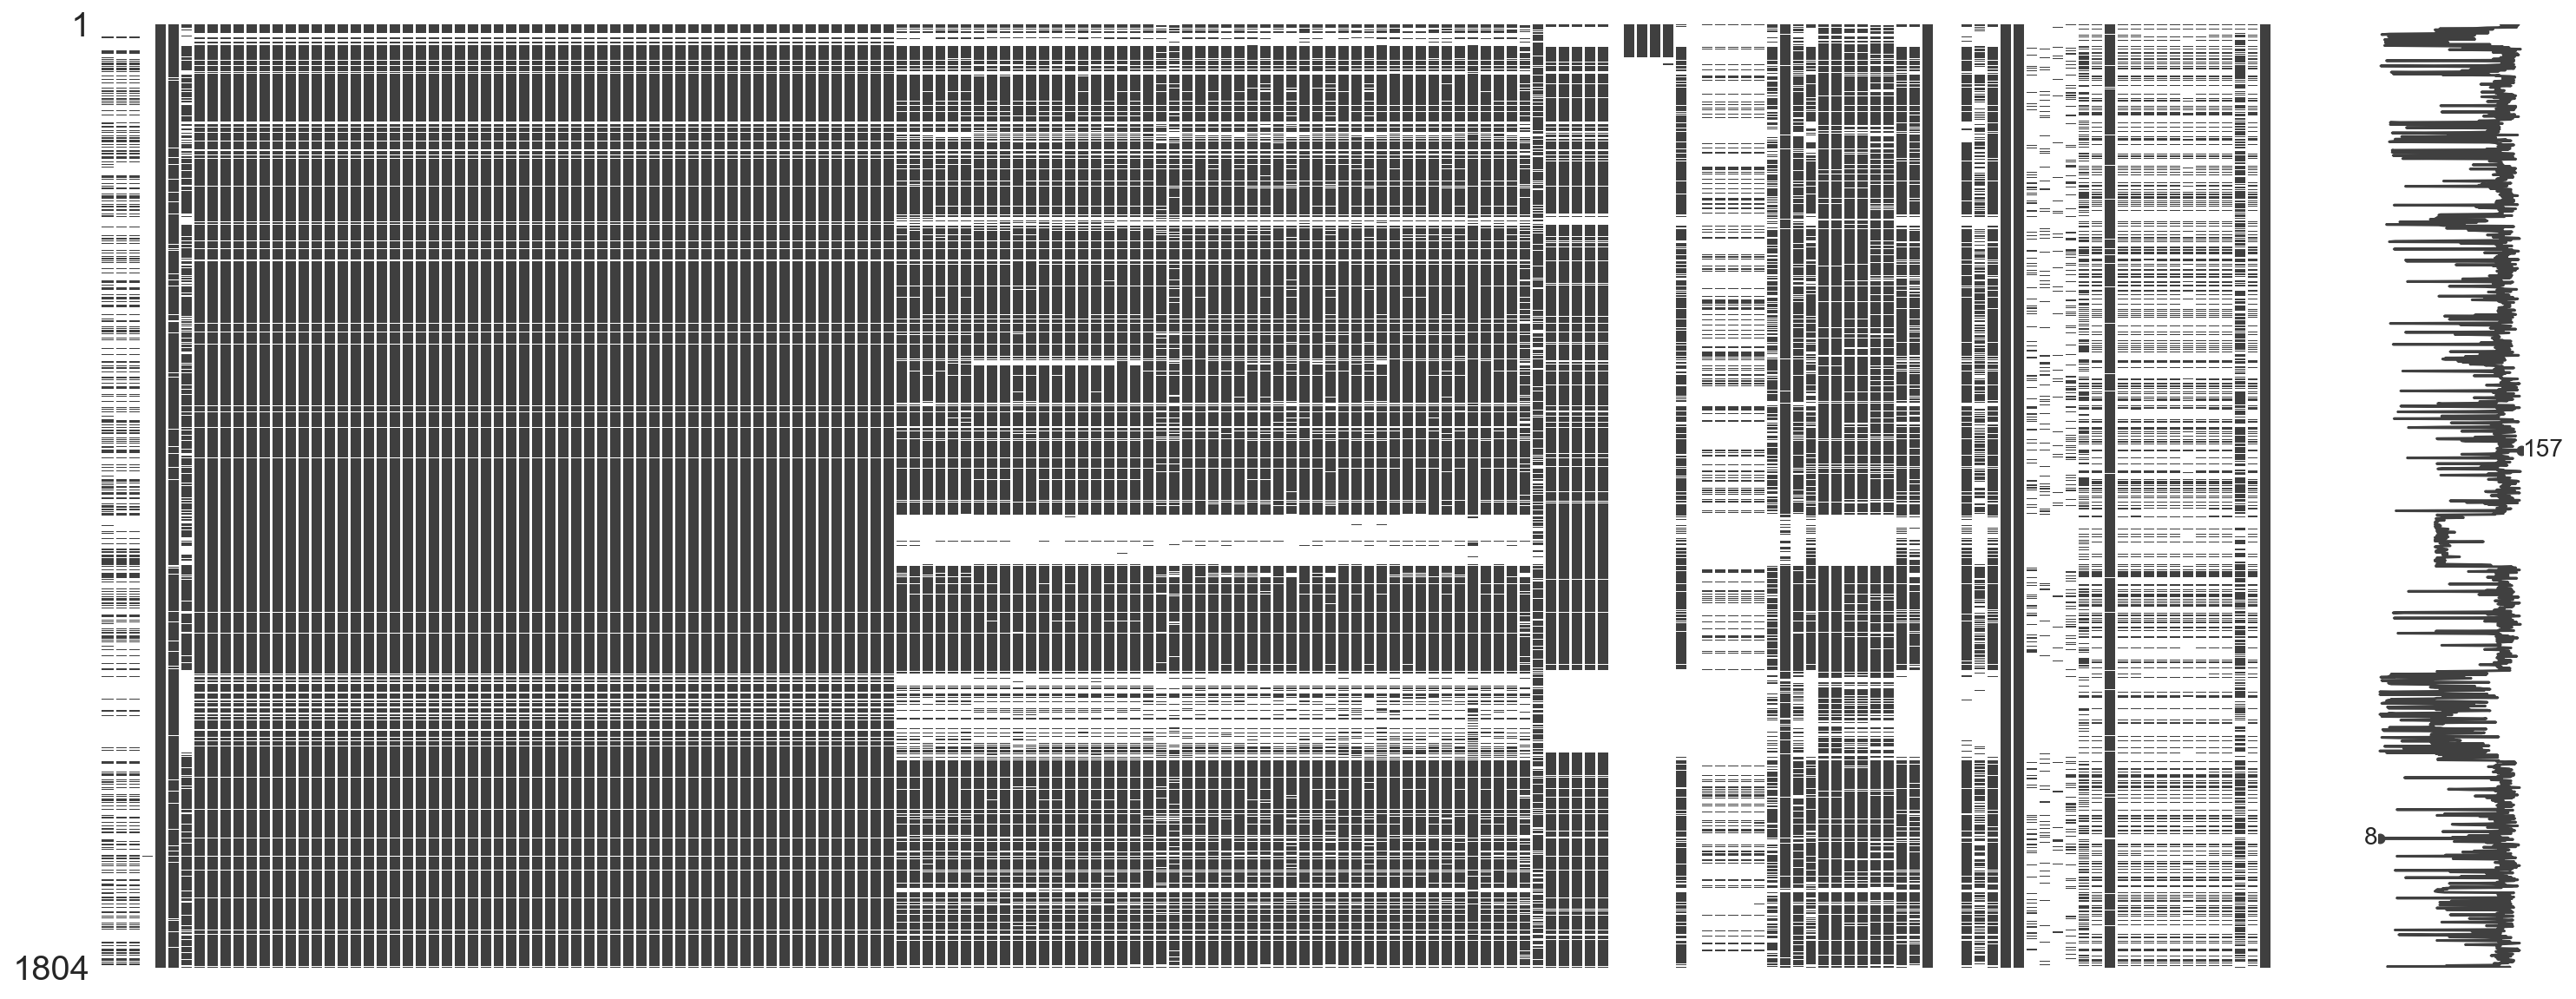

In [8]:
msno.matrix(data)
# msno.heatmap(data)

In [9]:
data.isnull().sum()

REVEL.max                         1240
MetaSVM_rankscore.max             1284
MetaLR_rankscore.max              1284
MCAP.max                          1800
wgEncodeBroadHmmHuvecHMM.count       0
                                  ... 
integrated_fitCons_rankscore      1274
LoFtool                            621
GERP_Rankscore                    1274
BPlabel                              0
BPlabel_encoded                   1804
Length: 168, dtype: int64

In [10]:
natest = data.isnull().sum()
natest.sort_values(inplace=True)
# natest.to_csv('traininggenes_features_with_NA.csv')

In [11]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame(
    {"column_name": data.columns, "percent_missing": percent_missing}
)
missing_value_df.sort_values("percent_missing", inplace=True)

In [12]:
natest = natest.to_frame()
missingdata = natest.join(missing_value_df)

In [13]:
missingdata.to_csv("unknownggenes_features_with_NA.csv")

<BarContainer object of 168 artists>

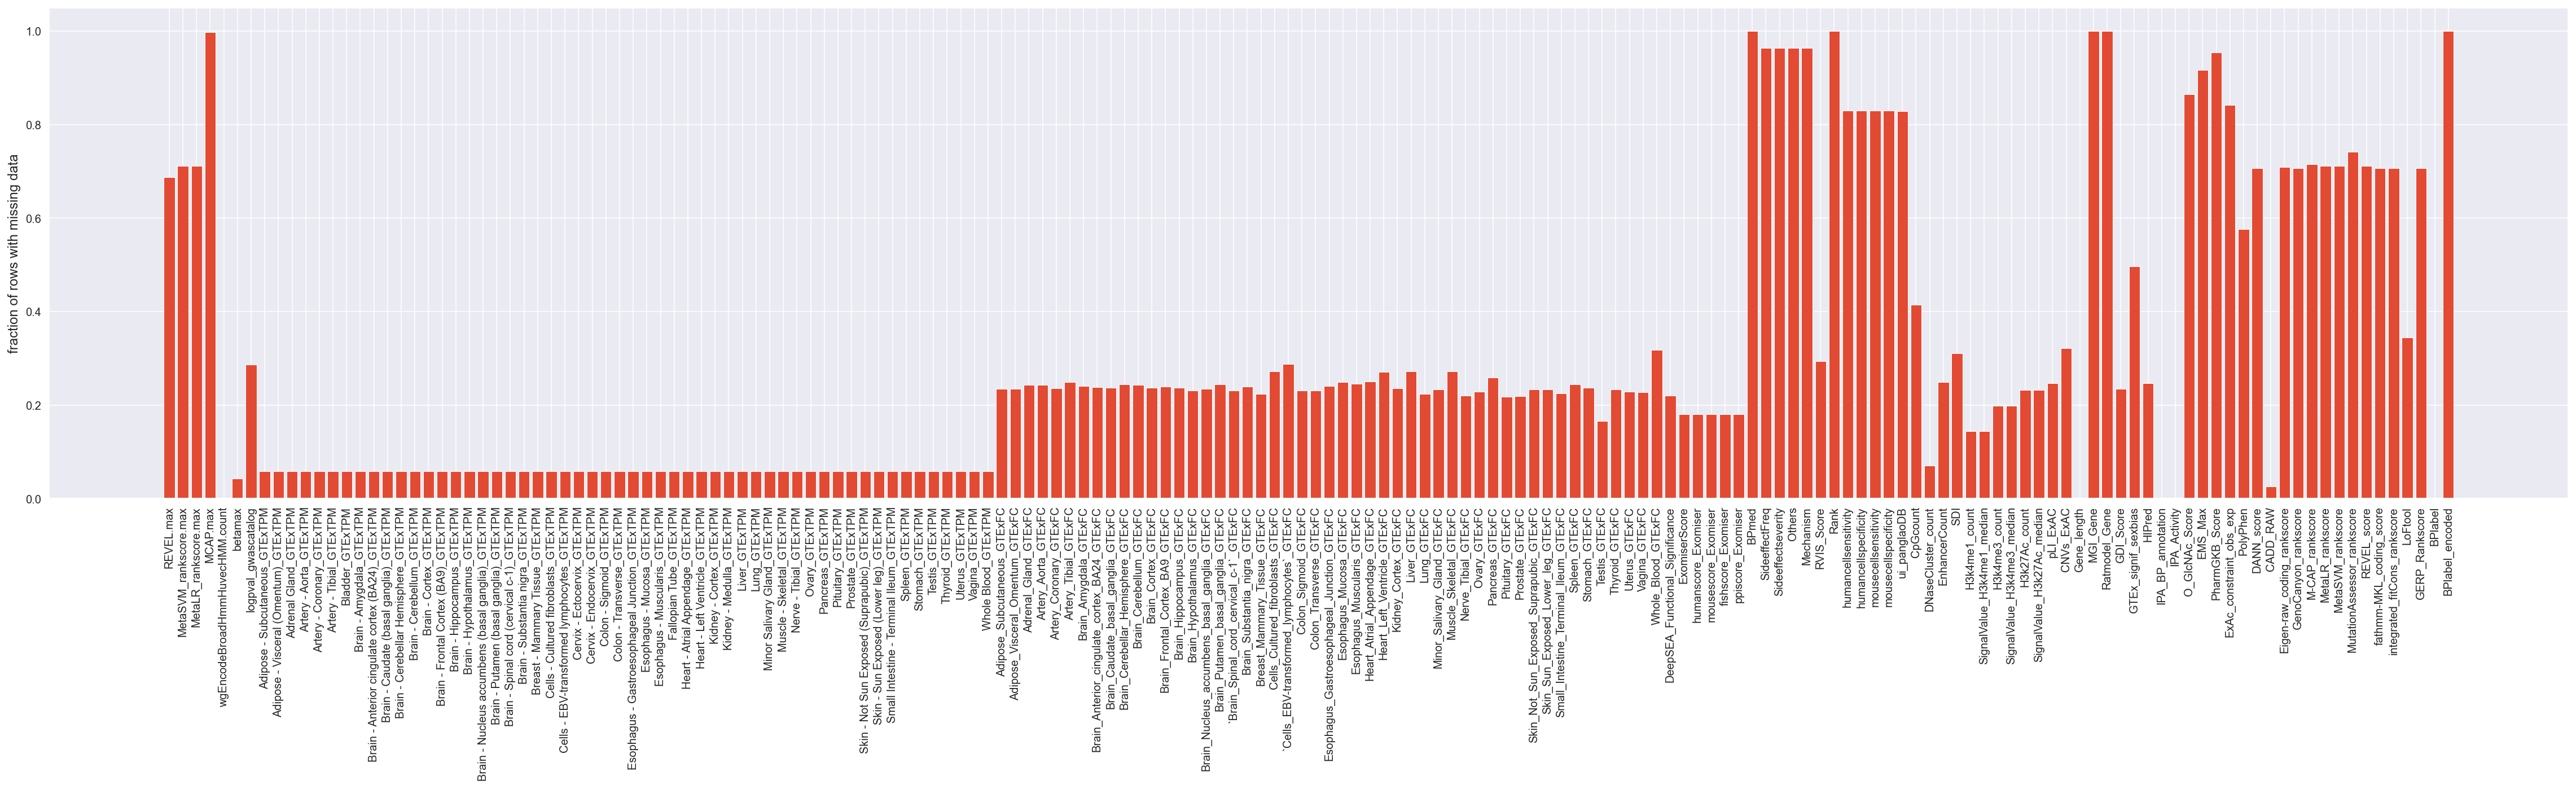

In [14]:
null_counts = data.isnull().sum() / len(data)
plt.figure(figsize=(40, 8))
plt.xticks(np.arange(len(null_counts)) + 0.0, null_counts.index, rotation="vertical")
plt.ylabel("fraction of rows with missing data")
plt.bar(np.arange(len(null_counts)), null_counts)

<BarContainer object of 8 artists>

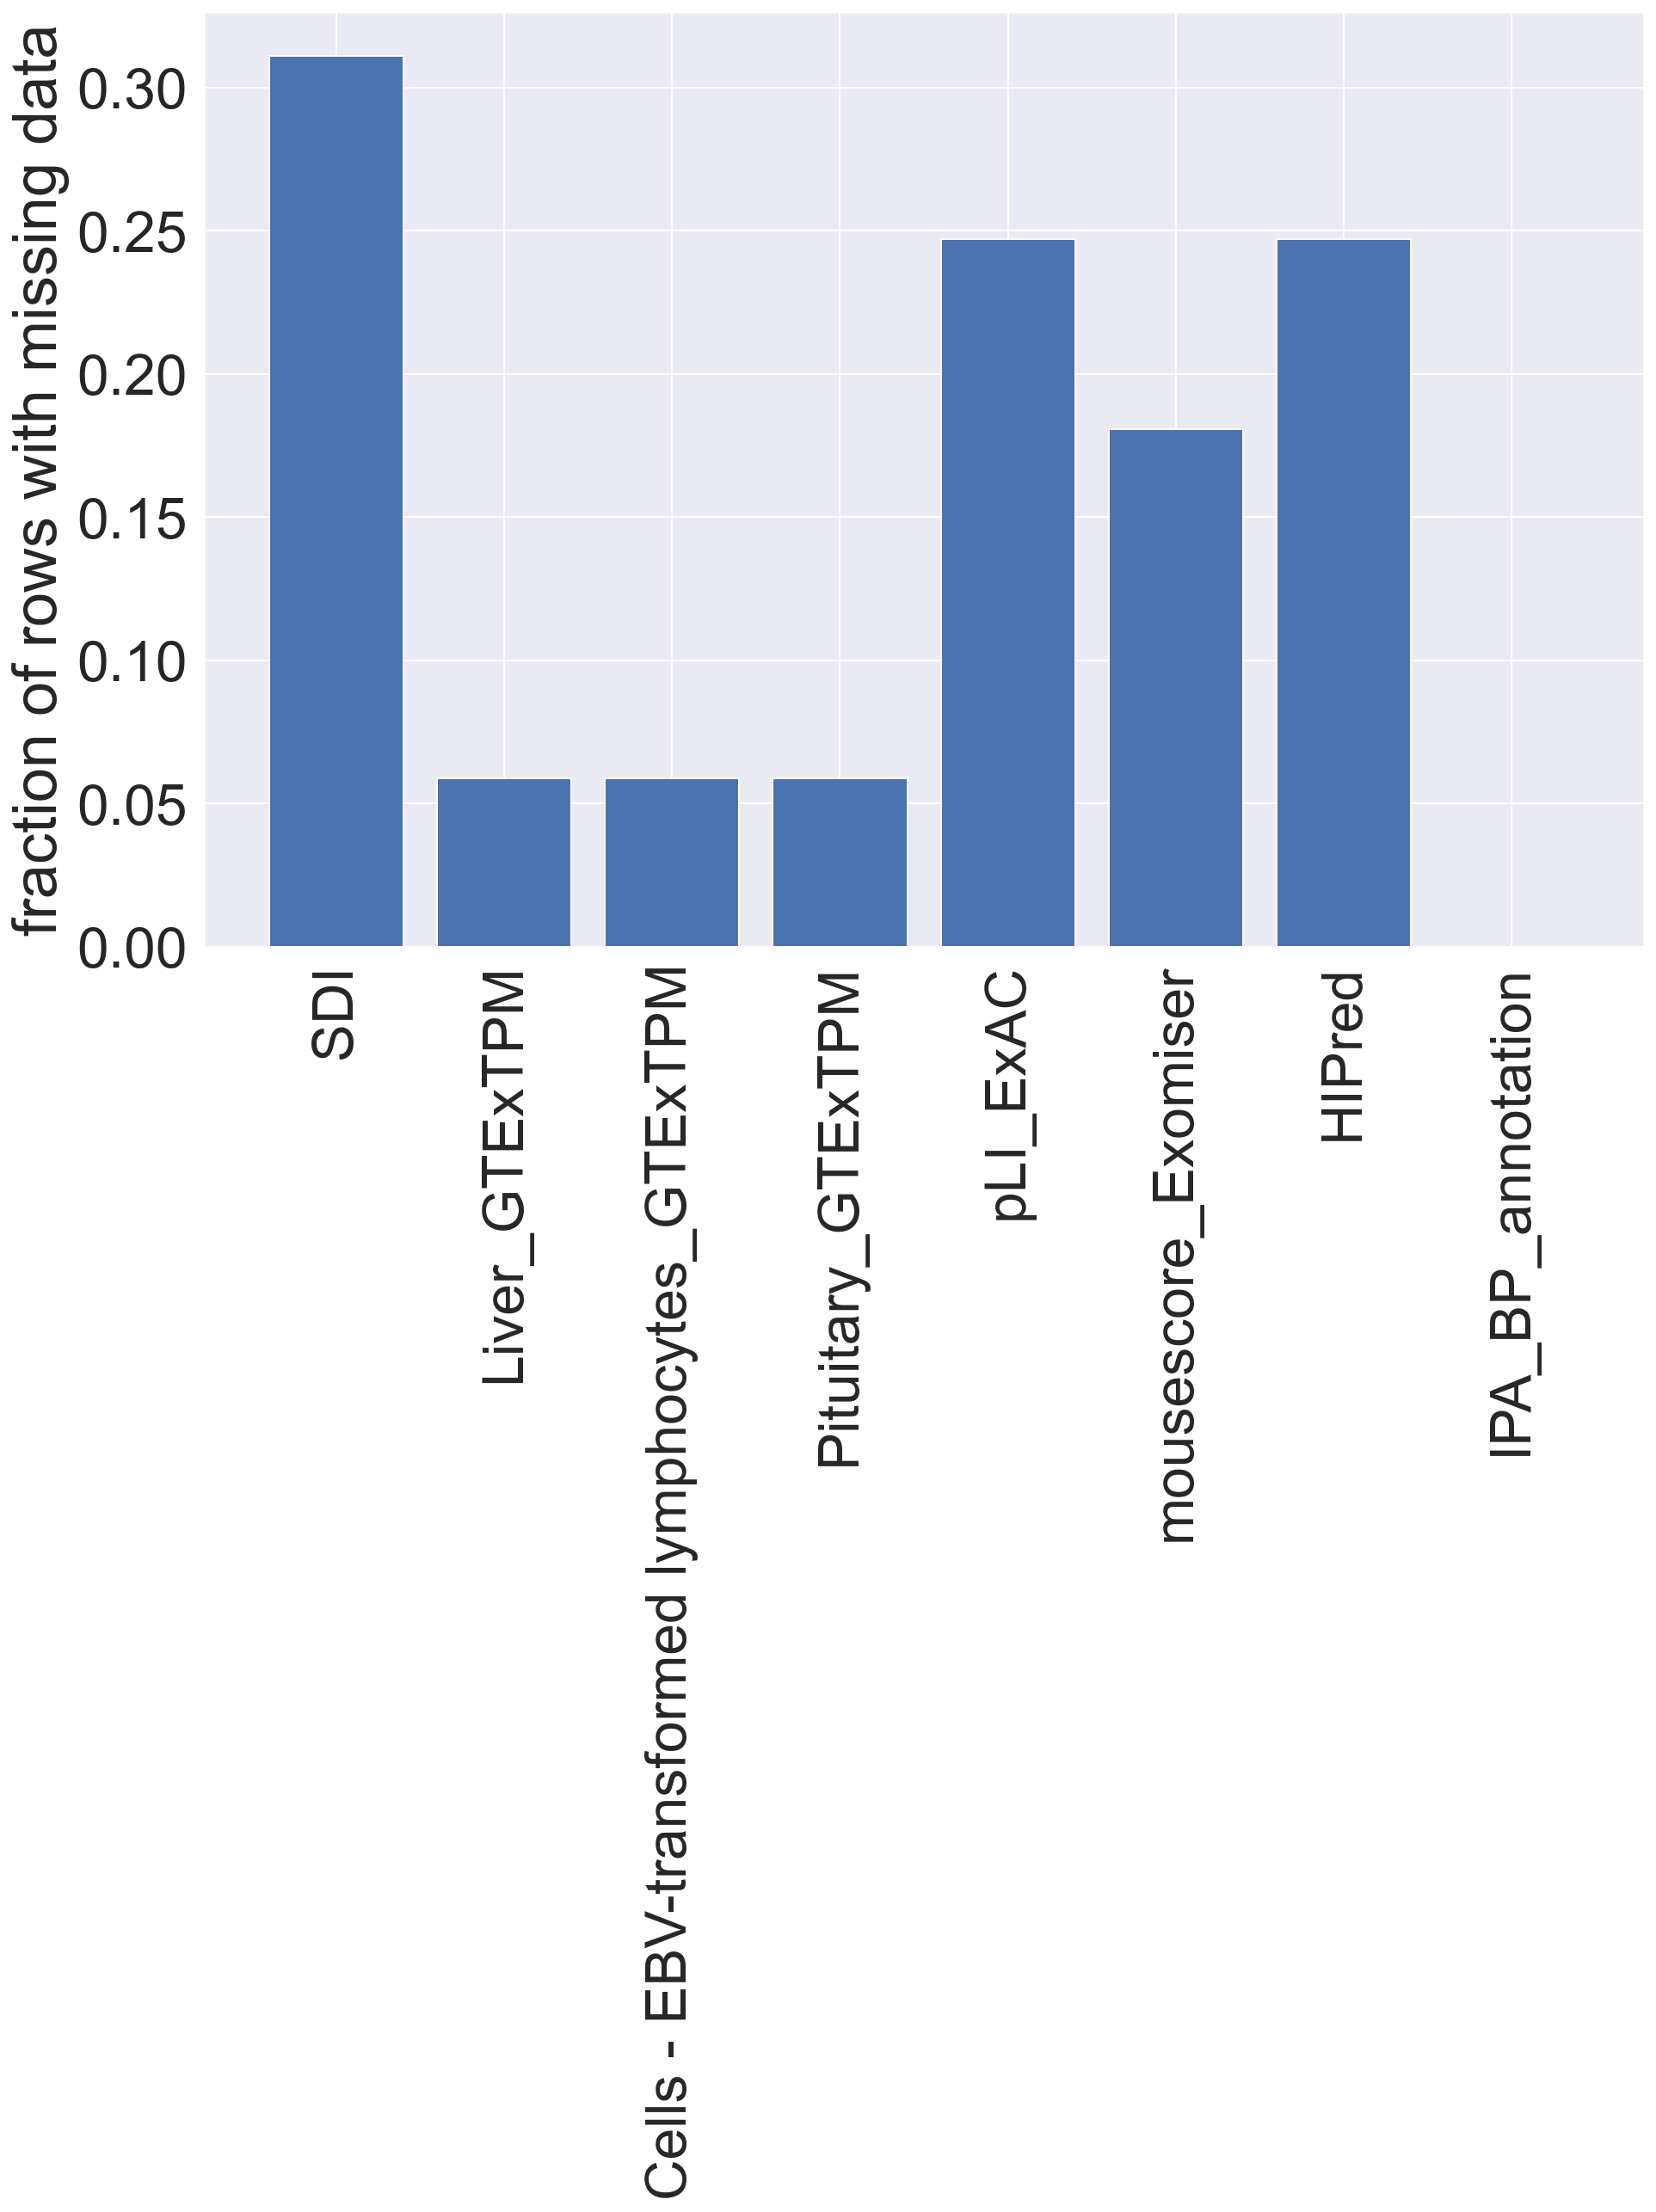

In [28]:
data_selected = data[
    [
        "SDI",
        "Liver_GTExTPM",
        "Cells - EBV-transformed lymphocytes_GTExTPM",
        "Pituitary_GTExTPM",
        "pLI_ExAC",
        "mousescore_Exomiser",
        "HIPred",
        "IPA_BP_annotation",
    ]
]
null_counts = data_selected.isnull().sum() / len(data_selected)
plt.figure(figsize=(15, 10))
plt.xticks(np.arange(len(null_counts)) + 0.0, null_counts.index, rotation="vertical")
plt.ylabel("fraction of rows with missing data")
plt.bar(np.arange(len(null_counts)), null_counts)

In [45]:
selection = dataset[
    [
        "Gene",
        "BPlabel",
        "SDI",
        "Liver_GTExTPM",
        "Cells - EBV-transformed lymphocytes_GTExTPM",
        "Pituitary_GTExTPM",
        "pLI_ExAC",
        "mousescore_Exomiser",
        "HIPred",
        "IPA_BP_annotation",
        "Gene_length",
    ]
]

In [46]:
dt2 = selection
dat = dt2.set_index("Gene")

## Feature Correlation:

In [47]:
df = dt2
df = df.set_index("Gene")
# df["BPlabel_encoded"] = df["BPlabel"].map(
#    {"most likely": 1, "probable": 0.75, "least likely": 0.1}
# )

# removing remaining variant-level features strongly correlating with gene length:
df = df.drop(["BPlabel", "Gene_length"], 1,)
df.shape

(1804, 8)

In [48]:
X = MinMaxScaler().fit_transform(df)
imputer = MissForest(random_state=seed)
X = pd.DataFrame(imputer.fit_transform(X), index=df.index, columns=df.columns)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [49]:
Xcor = X

Xcor = pd.DataFrame(data=Xcor, columns=X.columns)

corr = Xcor.corr(method="spearman")

f, ax = plt.subplots(figsize=(60, 50))

cmap = sns.diverging_palette(10, 275, as_cmap=True)
sns.set(font_scale=3)

sns.heatmap(
    corr,
    cmap=cmap,
    square=True,
    xticklabels=True,
    yticklabels=True,
    linewidths=0.5,
    ax=ax,
)

corr_matrix = data.corr()
# print(corr_matrix["BPlabel_encoded"].sort_values(ascending=False))
# corr = corr_matrix["BPlabel_encoded"].sort_values(ascending=False)

In [50]:
corr.to_csv("unknown_correlation.csv", header=True)

In [51]:
corr = X.corr()
corr.head()

,SDI,Liver_GTExTPM,Cells - EBV-transformed lymphocytes_GTExTPM,Pituitary_GTExTPM,pLI_ExAC,mousescore_Exomiser,HIPred,IPA_BP_annotation
SDI,1.000000,0.107841,0.223731,0.220626,0.266271,0.213302,0.427908,0.127141
Liver_GTExTPM,0.107841,1.000000,0.186287,0.184150,0.006730,0.009438,0.039584,0.053683
Cells - EBV-transformed lymphocytes_GTExTPM,0.223731,0.186287,1.000000,0.663415,0.162746,0.026306,0.192159,-0.021762
Pituitary_GTExTPM,0.220626,0.184150,0.663415,1.000000,0.162002,0.027034,0.217049,-0.002006
pLI_ExAC,0.266271,0.006730,0.162746,0.162002,1.000000,0.133354,0.699263,0.081880


In [52]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop

[]

### Viewing genes >25% missing rowwise for selected features (after running BorutaShap)

In [53]:
dt = dt2[
    [
        "SDI",
        "Liver_GTExTPM",
        "Cells - EBV-transformed lymphocytes_GTExTPM",
        "Pituitary_GTExTPM",
        "pLI_ExAC",
        "mousescore_Exomiser",
        "HIPred",
        "IPA_BP_annotation",
    ]
]

In [54]:
dt["missing_count"] = dt.isnull().sum(axis=1)  # dt.apply(lambda x: x.count(), axis=1)

dt["missing_percentage"] = (dt["missing_count"] / 19) * 100

dt.sort_values("missing_percentage", inplace=True)
print(dt[["missing_count", "missing_percentage"]])
# dt.shape

      missing_count  missing_percentage
0                 0            0.000000
1063              0            0.000000
1061              0            0.000000
1060              0            0.000000
1059              0            0.000000
...             ...                 ...
1281              7           36.842105
1279              7           36.842105
383               7           36.842105
40                7           36.842105
1317              7           36.842105

[1804 rows x 2 columns]


In [55]:
dtmissing = dt.loc[dt["missing_percentage"] > 25]
dtmissing

,SDI,Liver_GTExTPM,Cells - EBV-transformed lymphocytes_GTExTPM,Pituitary_GTExTPM,pLI_ExAC,mousescore_Exomiser,HIPred,IPA_BP_annotation,missing_count,missing_percentage
741,NaN,NaN,NaN,NaN,4.375617e-08,NaN,0.308604,0,5,26.315789
346,NaN,NaN,NaN,NaN,5.788140e-09,NaN,0.533326,0,5,26.315789
612,NaN,NaN,NaN,NaN,9.398162e-01,NaN,0.767621,0,5,26.315789
1247,NaN,NaN,NaN,NaN,9.963100e-01,NaN,0.372193,0,5,26.315789
198,NaN,NaN,NaN,NaN,9.785361e-01,NaN,0.435046,0,5,26.315789
...,...,...,...,...,...,...,...,...,...,...
1281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7,36.842105
1279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7,36.842105
383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7,36.842105
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7,36.842105


### Gene length distribution:


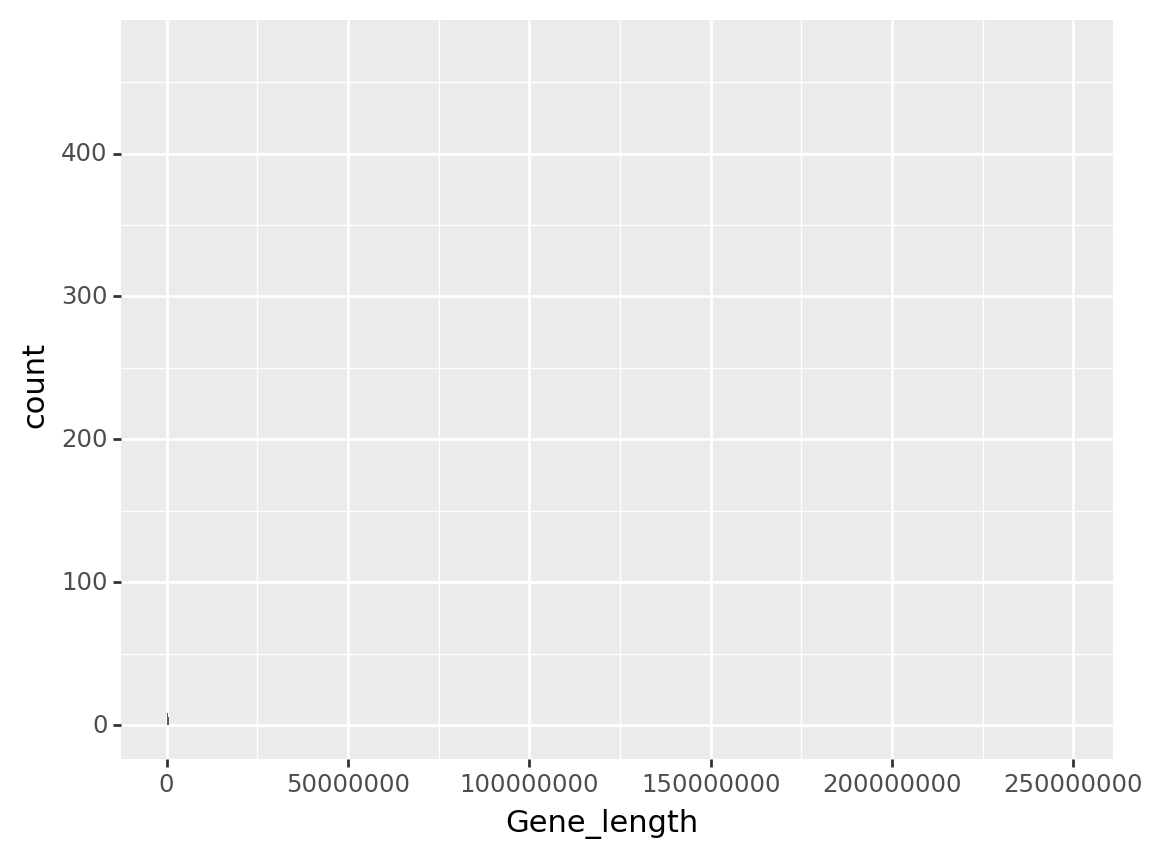

<ggplot: (8766012040099)>

In [56]:
(ggplot(dat, aes(x="Gene_length")) + geom_histogram())

### Feature distribution:

In [66]:
def draw_histograms(dataf, variables, n_rows, n_cols):
    fig = plt.figure()
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        df[var_name].hist(
            bins=40,
            linewidth=1.0,
            xlabelsize=18,
            ylabelsize=18,
            figsize=(30, 30),
            ax=ax,
        )
        ax.set_title(var_name + " Distribution")
    fig.tight_layout()
    plt.suptitle("Predicted Data Univariate Plots", y=1.02, fontsize=35)
    plt.savefig(
        "predicted_gene_feature_distribution.png", format="png", dpi=300, bbox_inches="tight"
    )
    plt.show()


#test = pd.DataFrame(np.random.randn(30, 9), columns=map(str, range(9)))
#draw_histograms(dt, dt.columns, 4, 2)

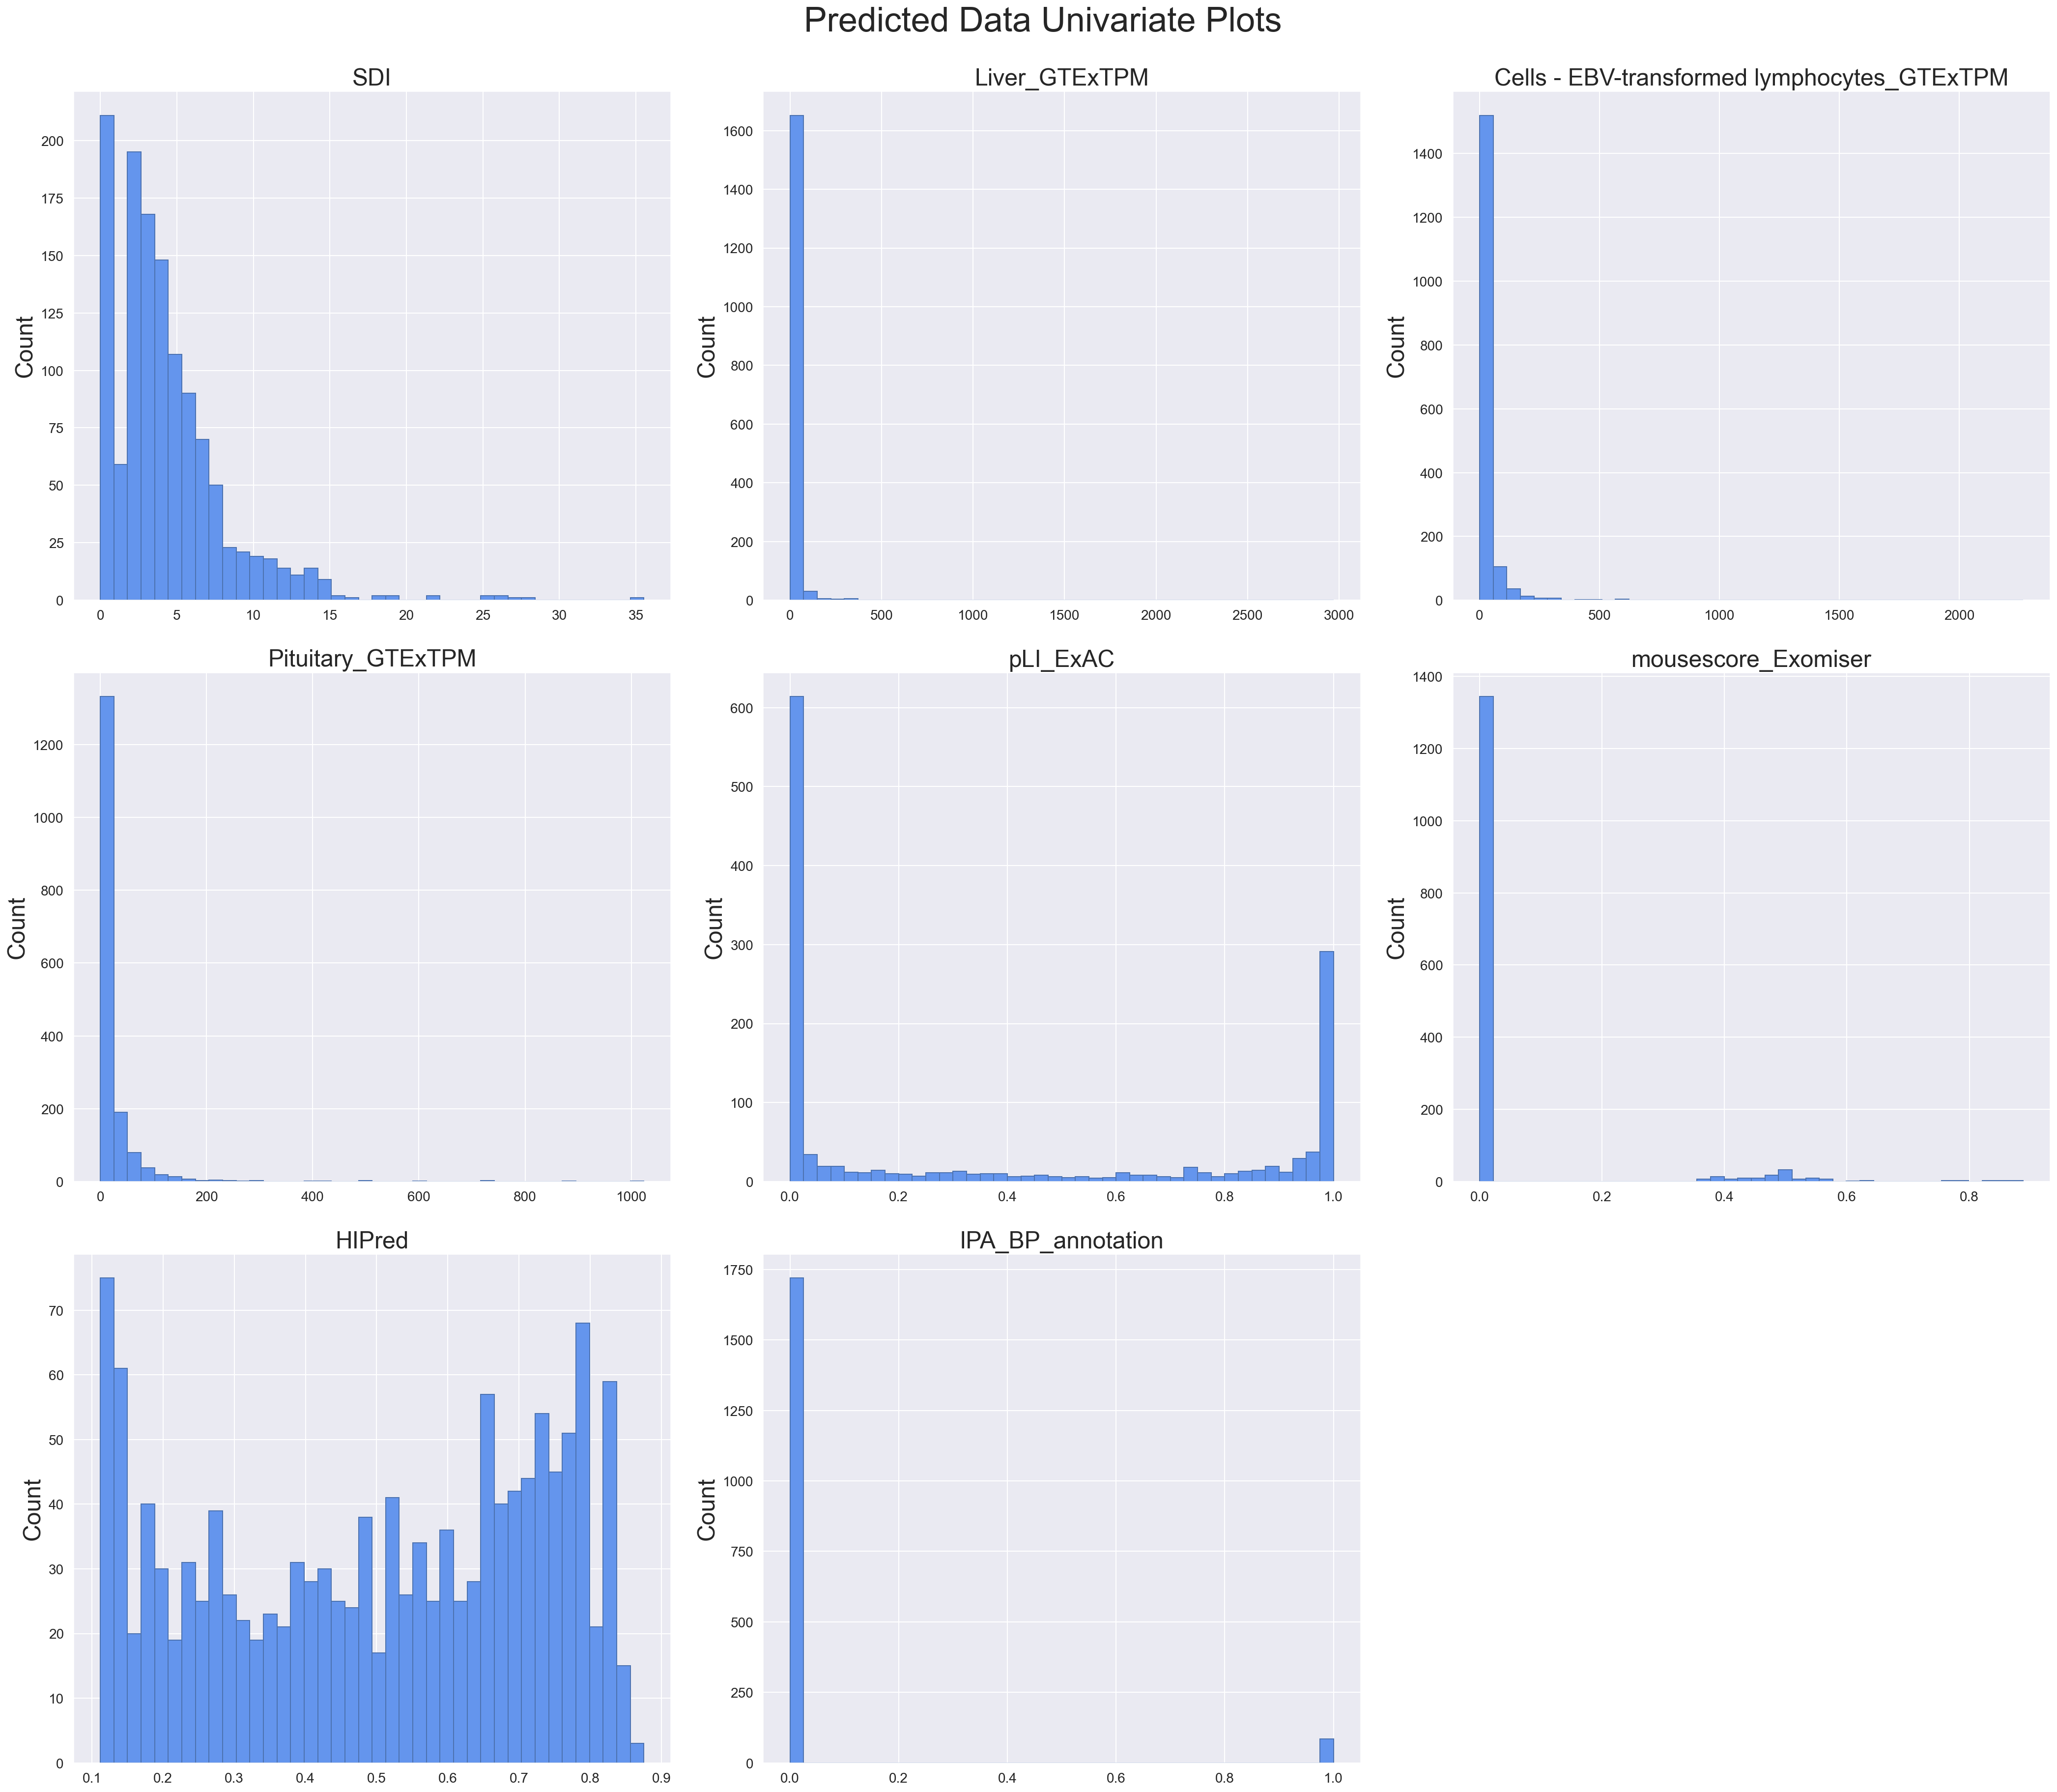

In [67]:
# features only selected by BorutaShap:
sns.set(font_scale=2)
features_list = [
        "SDI",
        "Liver_GTExTPM",
        "Cells - EBV-transformed lymphocytes_GTExTPM",
        "Pituitary_GTExTPM",
        "pLI_ExAC",
        "mousescore_Exomiser",
        "HIPred",
        "IPA_BP_annotation",
]


axarr = dt[features_list].hist(
    bins=40,
    edgecolor="b",
    linewidth=1.0,
    xlabelsize=14,
    ylabelsize=14,
    # grid=False,
    figsize=(30, 25),
    color="cornflowerblue",
)

for ax in axarr.flatten():
    ax.set_ylabel("Count")

plt.tight_layout()
plt.grid(axis="x", color="0.95")
plt.suptitle("Predicted Data Univariate Plots", y=1.02, fontsize=35)

plt.savefig(
    "predicted_gene_feature_distribution.png", format="png", dpi=300, bbox_inches="tight"
)

### Covariation Heatmaps:

Text(0.5, 1.0, 'Covariance between different features')

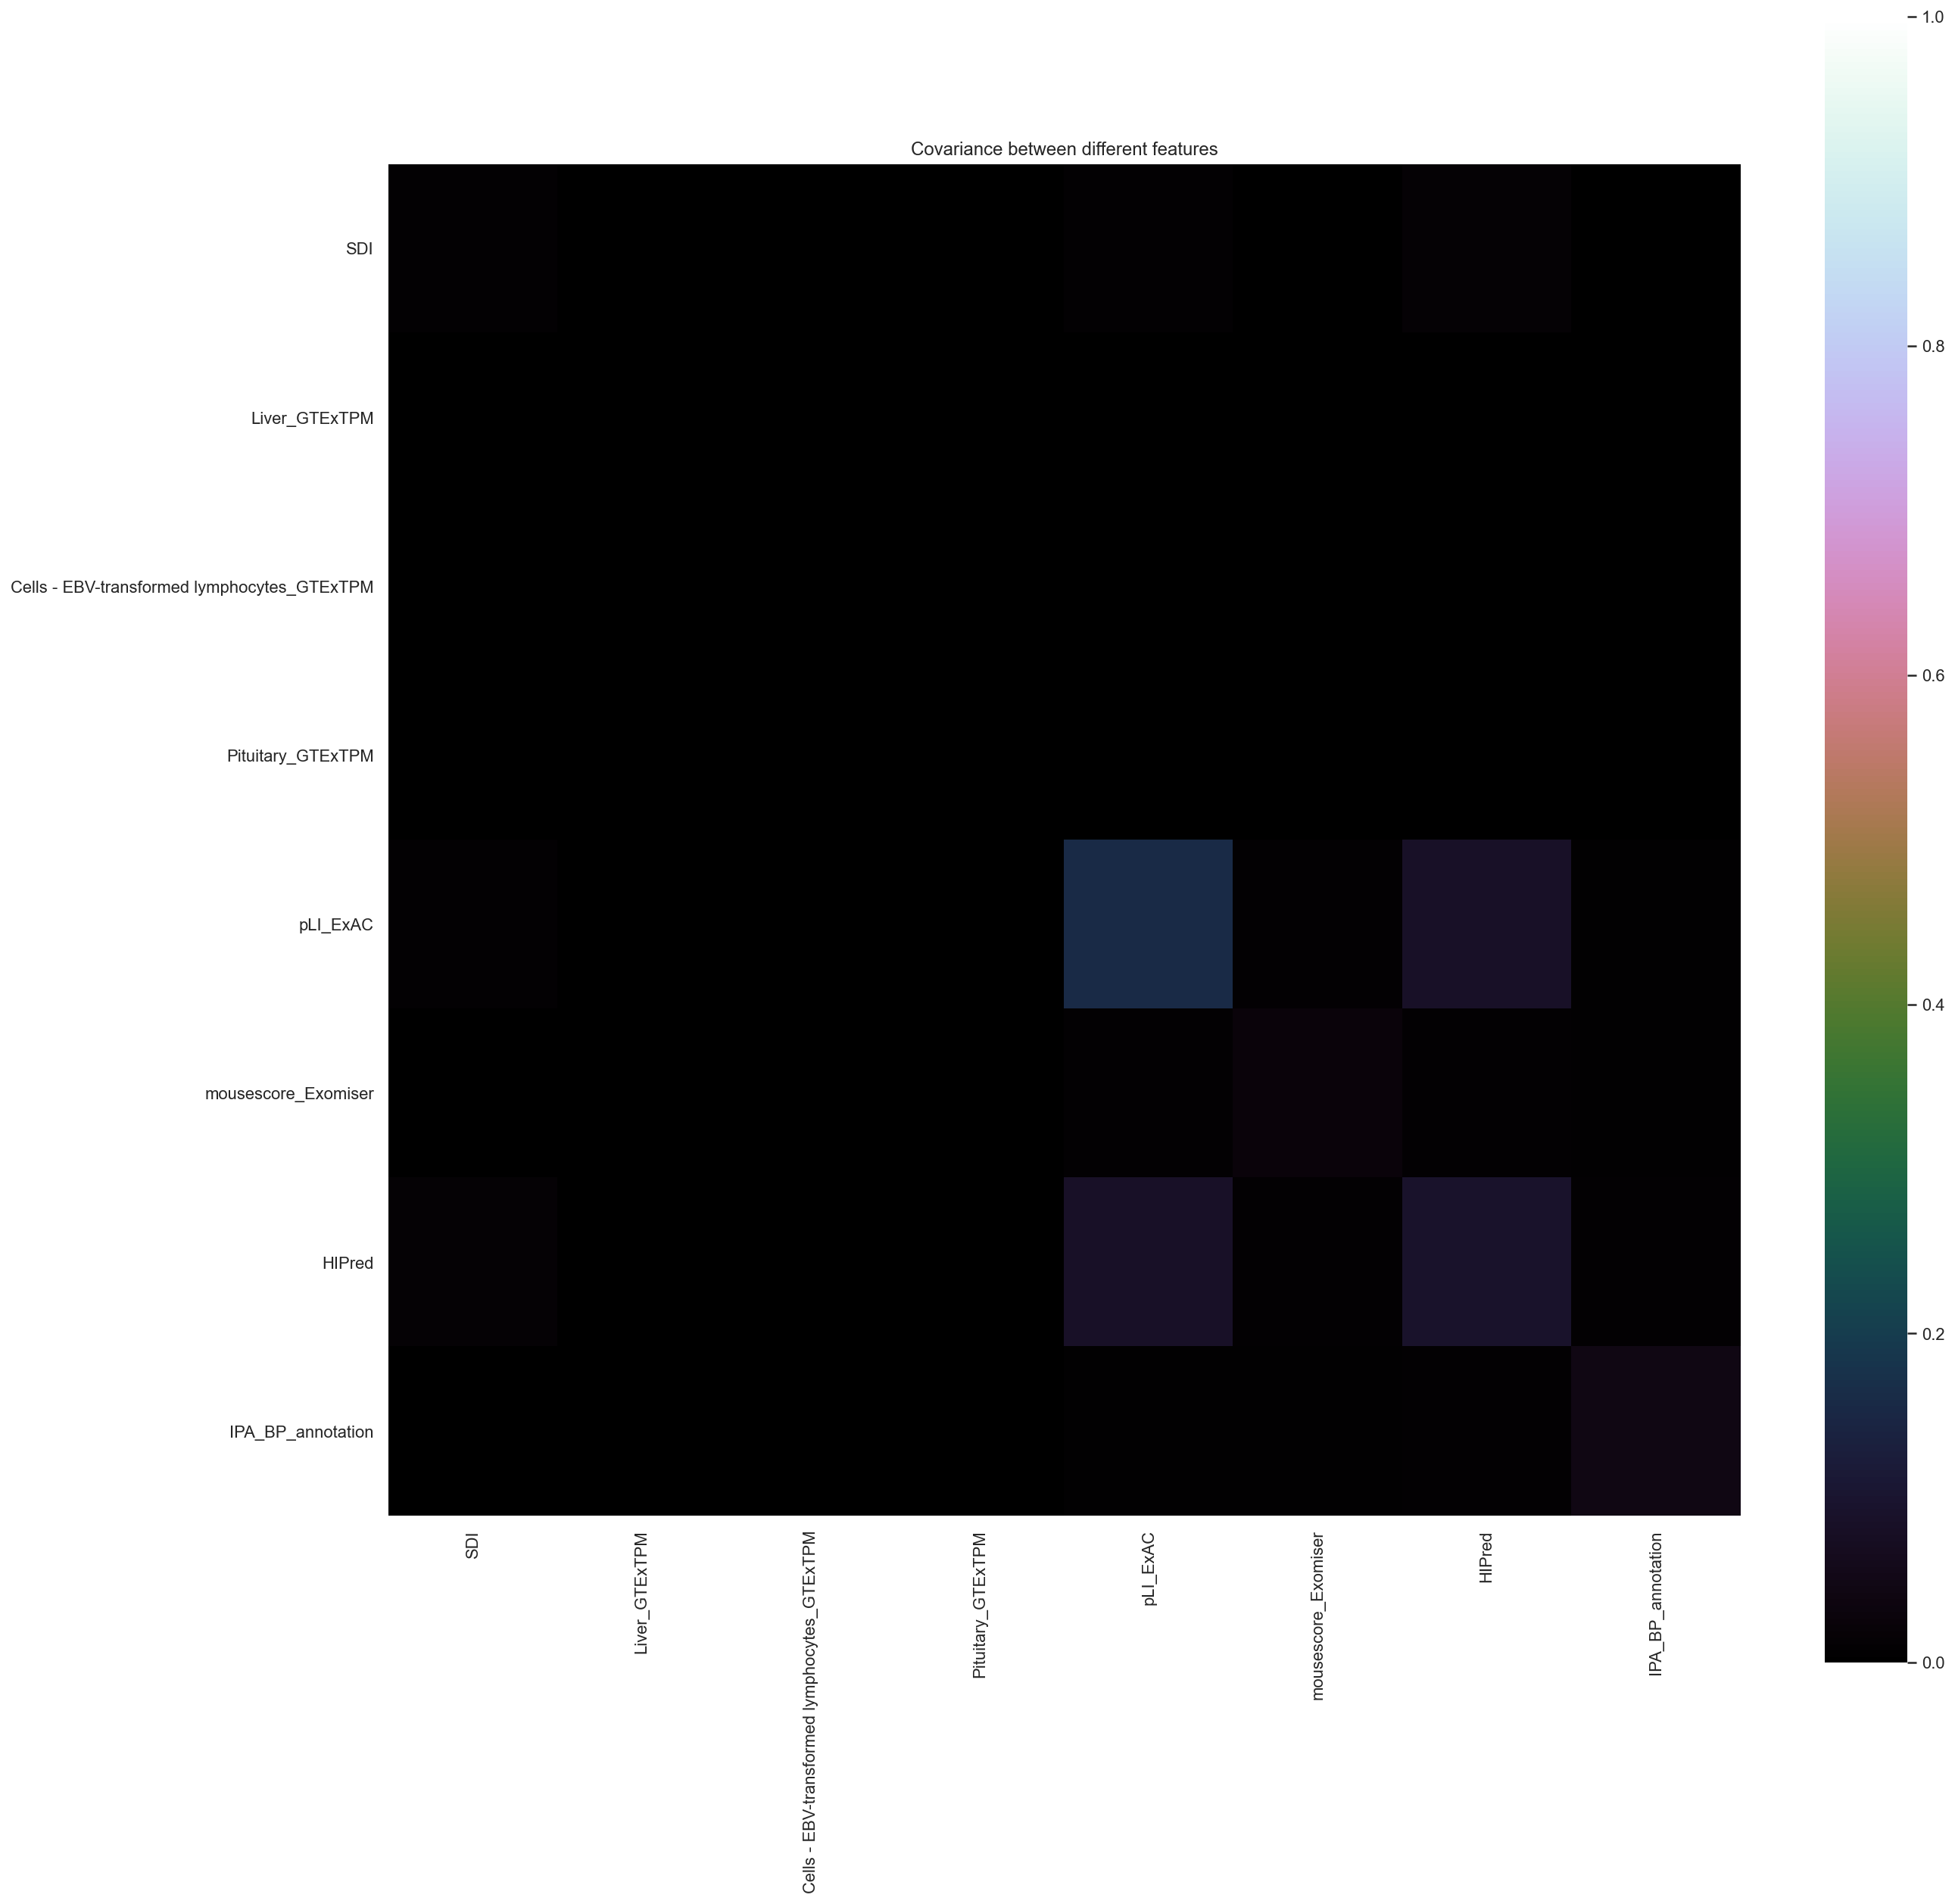

In [68]:
mean_vec = np.mean(Xcor, axis=0)
cov_mat = (Xcor - mean_vec).T.dot((Xcor - mean_vec)) / (Xcor.shape[0] - 1)
# print('Covariance matrix \n%s' %cov_mat)
sns.set(font_scale=1)
plt.figure(figsize=(20, 20))
sns.heatmap(cov_mat, vmax=1, square=True, cmap="cubehelix")

plt.title("Covariance between different features")

### Clustering to view training data grouping:

#### PCA Explained Variance 
- for deciding n components in hierarchal clustering

In [74]:
X2 = X[[    "SDI",
        "Liver_GTExTPM",
        "Cells - EBV-transformed lymphocytes_GTExTPM",
        "Pituitary_GTExTPM",
        "pLI_ExAC",
        "mousescore_Exomiser",
        "HIPred",
        "IPA_BP_annotation",]]
mean_vec = np.mean(X2, axis=0)
cov_mat = (X2 - mean_vec).T.dot((X2 - mean_vec)) / (X2.shape[0] - 1)

In [75]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print("Eigenvectors \n%s" % eig_vecs)
print("\nEigenvalues \n%s" % eig_vals)


# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print("Eigenvalues in descending order:")
for i in eig_pairs:
    print(i[0])

Eigenvectors 
[[ 7.72054815e-02  9.09060037e-02 -1.52028052e-01  9.06171968e-02
  -9.52766863e-01 -2.14552449e-01  2.51060147e-02 -4.86273954e-03]
 [ 1.32691170e-03  7.80630151e-03 -5.12918086e-03 -2.43834320e-03
  -3.99877512e-02  9.42203624e-02 -6.15603355e-01  7.81320075e-01]
 [ 1.62745469e-02 -4.13193636e-03 -2.12388858e-02  2.09575455e-03
  -1.24794369e-01  5.13085985e-01 -6.32126990e-01 -5.66433746e-01]
 [ 2.32082984e-02  7.23706081e-04 -3.67886352e-02 -2.26019281e-03
  -1.67153739e-01  8.25102362e-01  4.69884045e-01  2.61872187e-01]
 [ 8.20185449e-01 -2.27233368e-01  5.22935188e-01  3.10605423e-02
  -3.38264262e-02 -8.33188128e-03  1.02653175e-03  4.48962031e-03]
 [ 6.03405304e-02  2.55072463e-01 -3.24987559e-02  9.56698353e-01
   1.19948441e-01  2.39680040e-02 -1.81449696e-03  1.94032104e-03]
 [ 5.59599331e-01  1.93084802e-01 -7.74483943e-01 -1.34992551e-01
   1.77072039e-01 -1.18766408e-02 -4.55352455e-03 -1.47810664e-03]
 [ 6.11351445e-02  9.15247976e-01  3.17354550e-01 -2.39

In [76]:
tot = sum(eig_vals)
var_exp = [(i / tot) * 100 for i in sorted(eig_vals, reverse=True)]
len(var_exp)

8

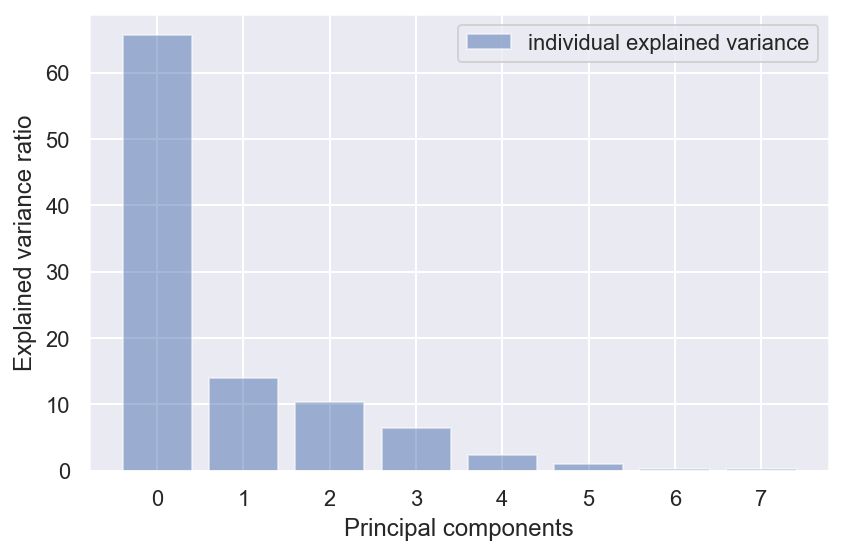

In [77]:
sns.set(font_scale=1)
plt.figure(figsize=(6, 4))

plt.bar(
    range(8), var_exp, alpha=0.5, align="center", label="individual explained variance"
)
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")
plt.legend(loc="best")
plt.tight_layout()

Text(0, 0.5, 'Cumulative explained variance')

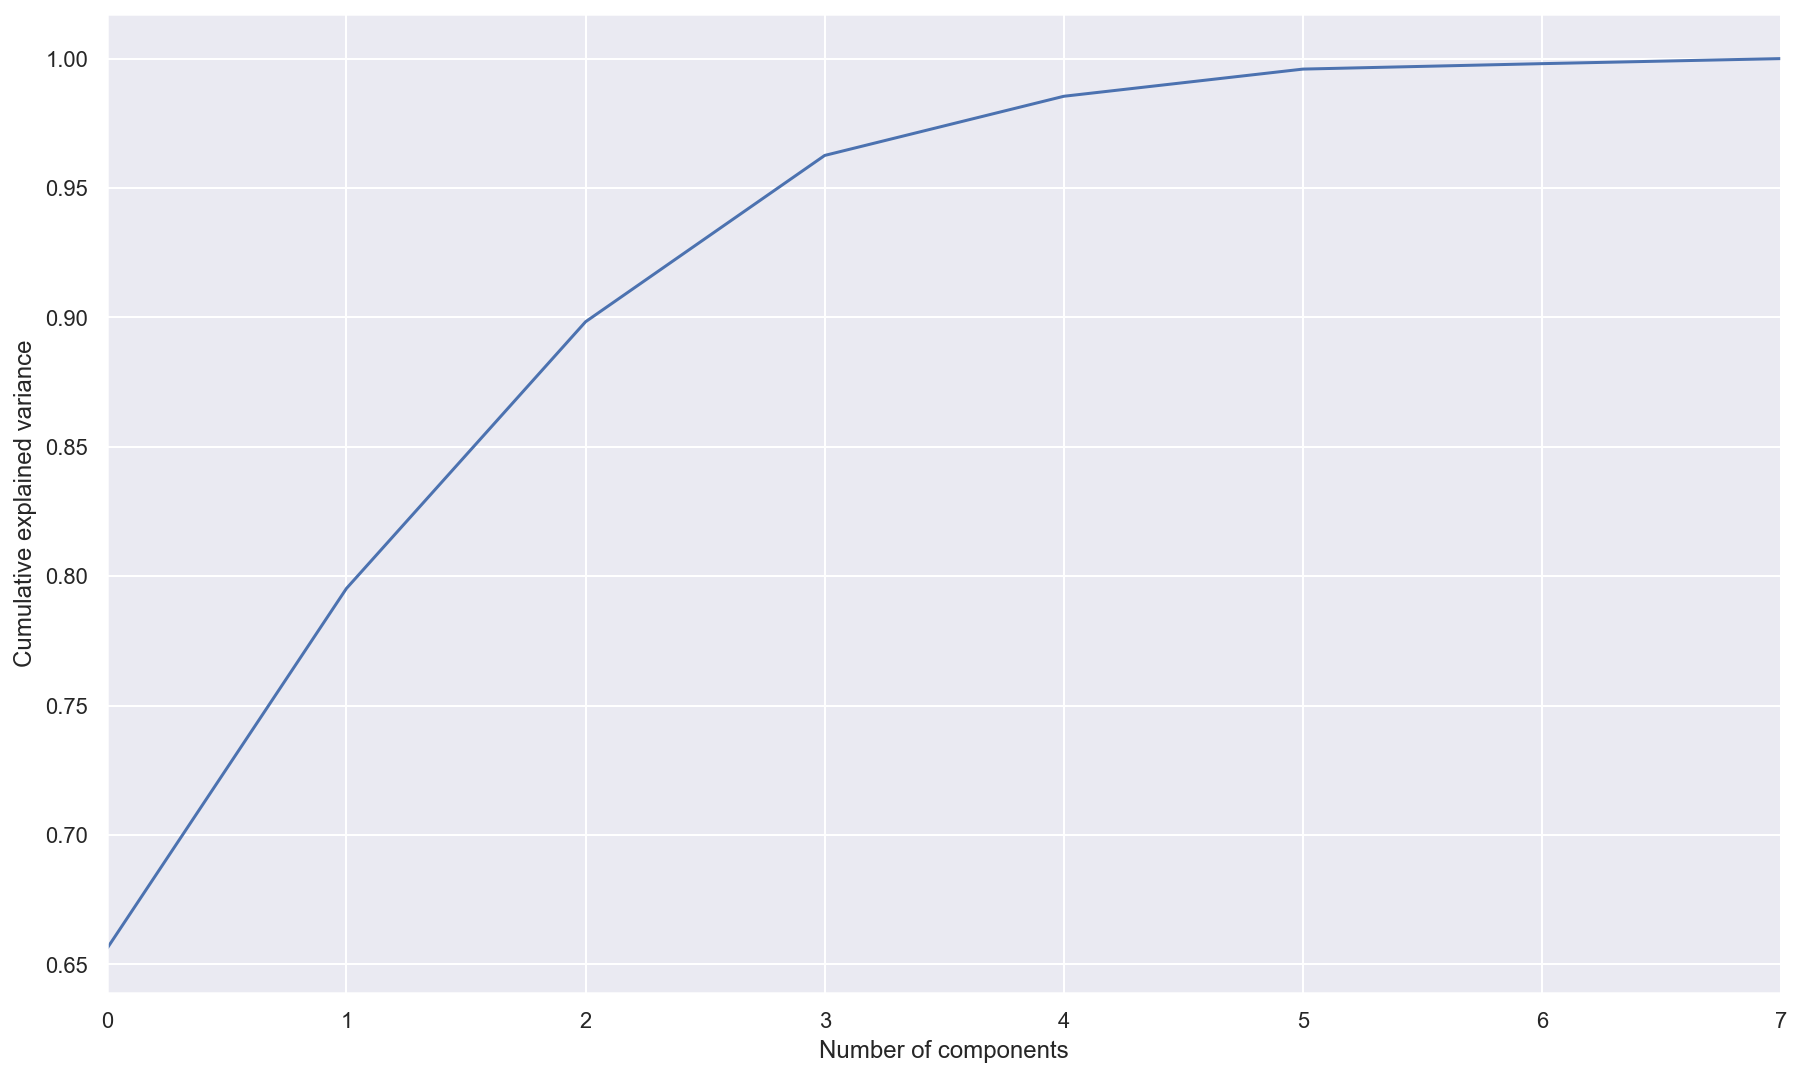

In [78]:
from sklearn.decomposition import PCA

pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0, 7, 1)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")

## Hierarchal Clustering

### All training data:

In [79]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop("max_d", None)
    if max_d and "color_threshold" not in kwargs:
        kwargs["color_threshold"] = max_d
    annotate_above = kwargs.pop("annotate_above", 0)
    plt.figure(figsize=(15, 10))
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get("no_plot", False):
        plt.title("Hierarchical Clustering Dendrogram (truncated)")
        plt.xlabel("sample index or (cluster size)")
        plt.ylabel("distance")
        for i, d, c in zip(ddata["icoord"], ddata["dcoord"], ddata["color_list"]):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, "o", c=c)
                plt.annotate(
                    "%.3g" % y,
                    (x, y),
                    xytext=(0, -5),
                    textcoords="offset points",
                    va="top",
                    ha="center",
                )
        if max_d:
            plt.axhline(y=max_d, c="k")
    return ddata

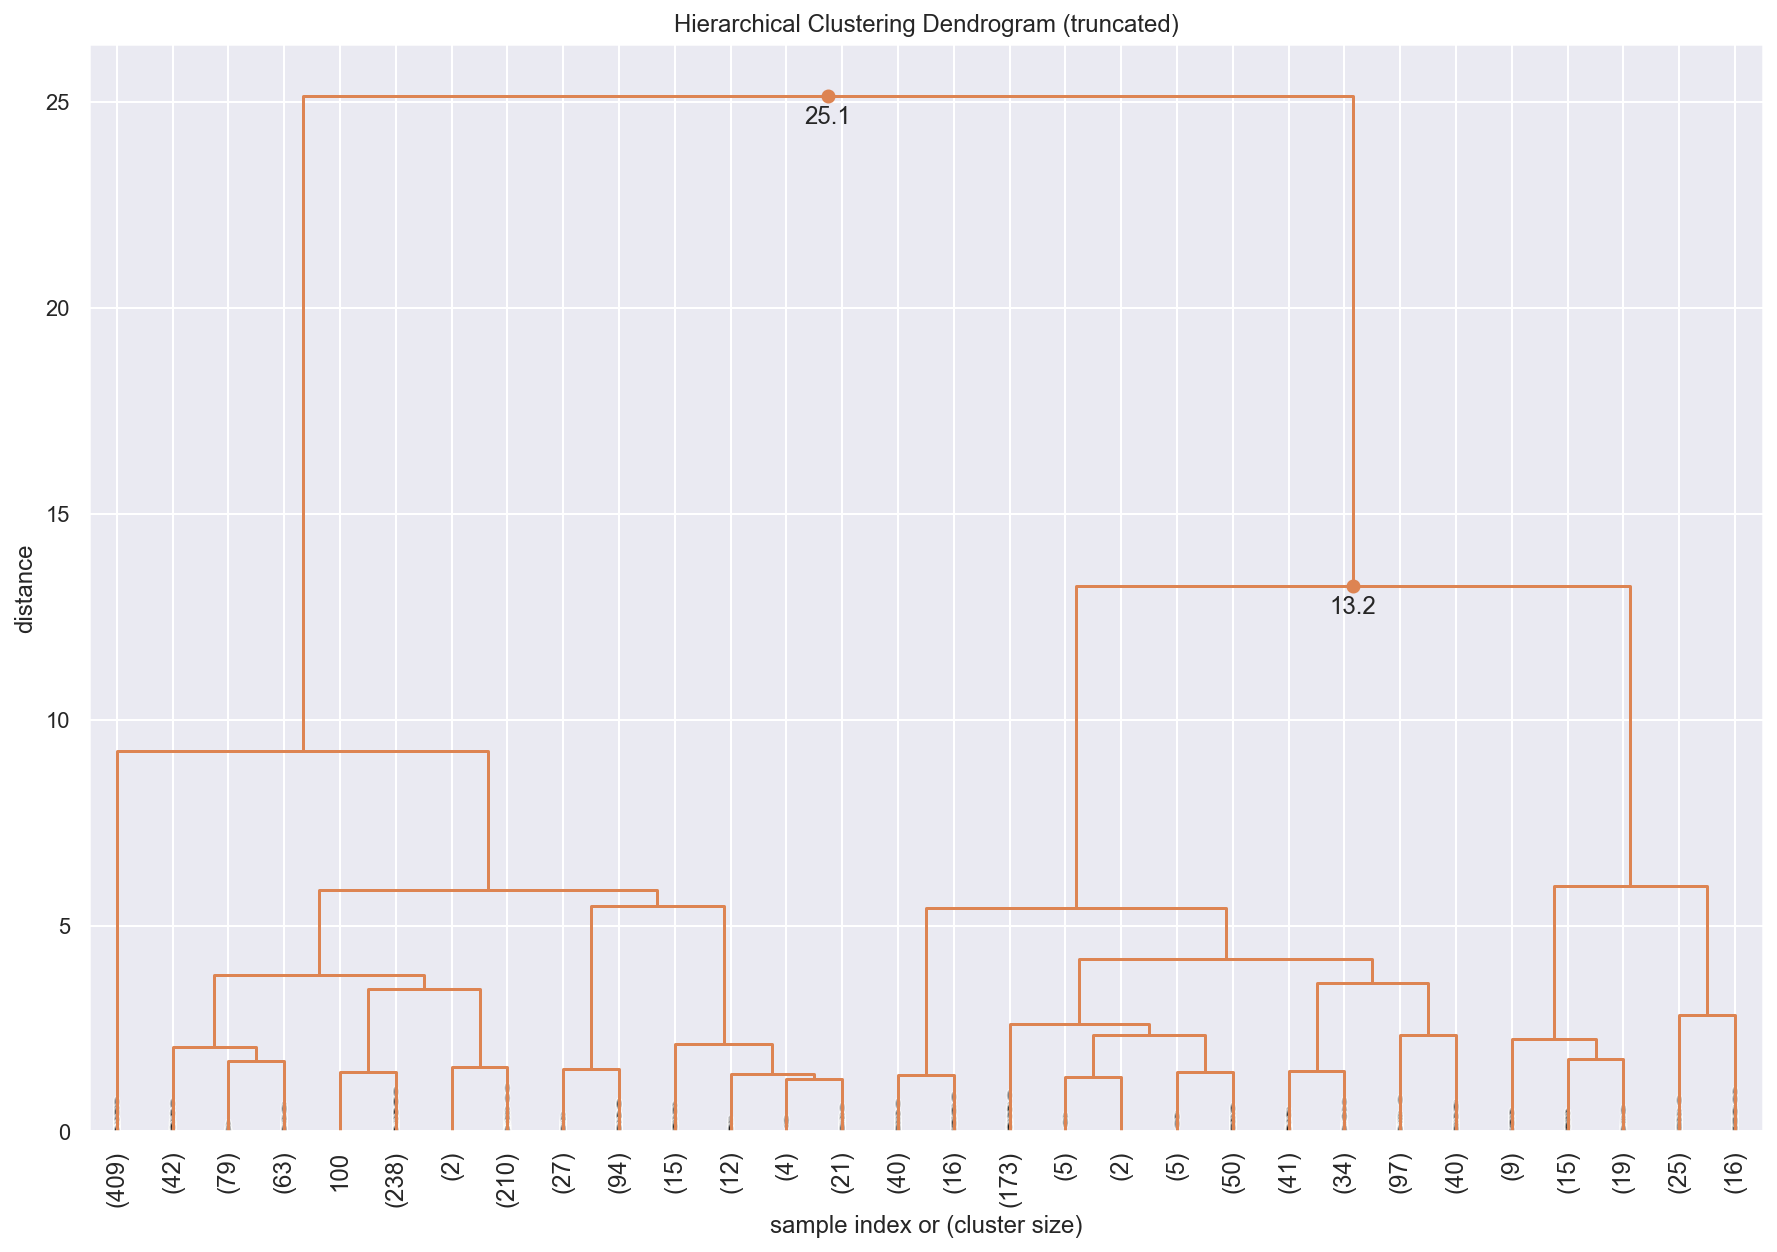

In [80]:
linked_array = ward(X2)

fancy_dendrogram(
    linked_array,
    truncate_mode="lastp",
    p=30,
    leaf_rotation=90.0,
    leaf_font_size=12.0,
    show_contracted=True,
    annotate_above=10,
    max_d=80,
)

plt.show()

In [81]:
X2.shape

(1804, 8)

In [82]:
# Reducing the dimensions of the data
pca = PCA(n_components=2)
X_principal = pca.fit_transform(X)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ["P1", "P2"]

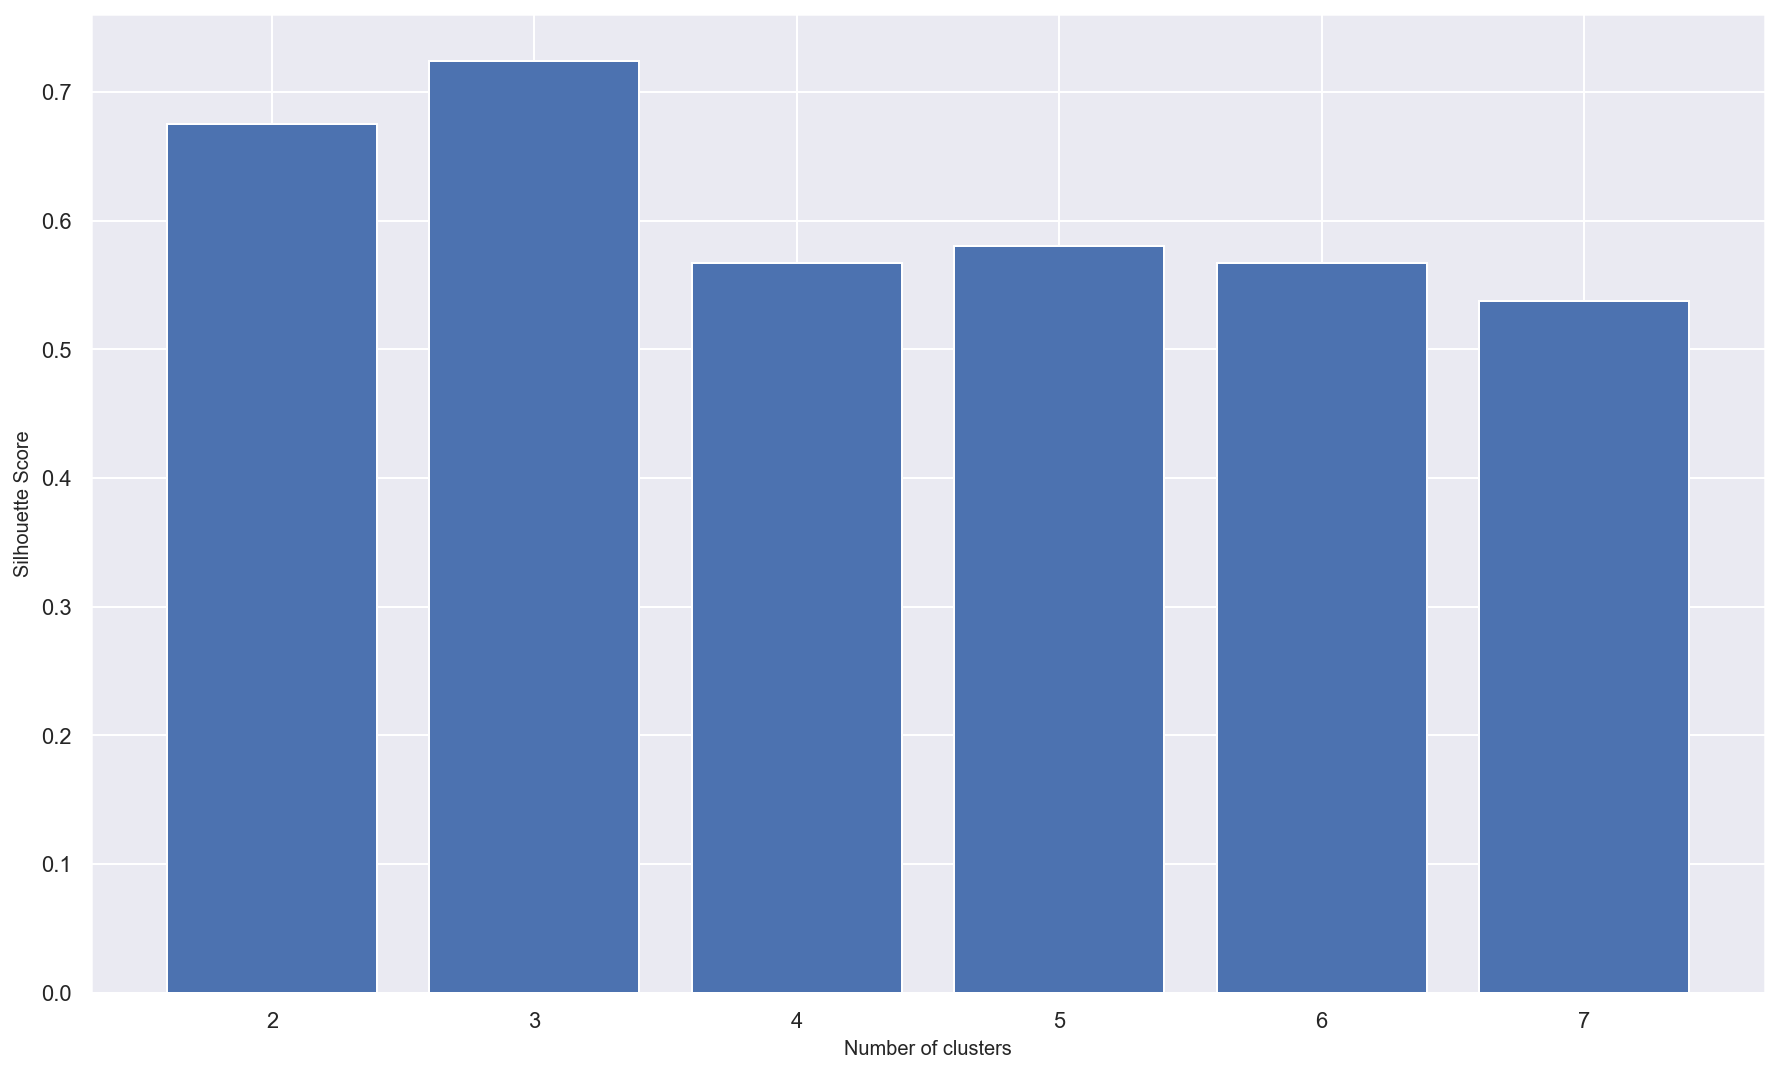

In [83]:
silhouette_scores = []

for n_cluster in range(2, 8):
    silhouette_scores.append(
        silhouette_score(
            X_principal,
            AgglomerativeClustering(n_clusters=n_cluster).fit_predict(X_principal),
        )
    )

# Plotting a bar graph to compare the results
k = [2, 3, 4, 5, 6, 7]
plt.bar(k, silhouette_scores)
plt.xlabel("Number of clusters", fontsize=10)
plt.ylabel("Silhouette Score", fontsize=10)
plt.show()

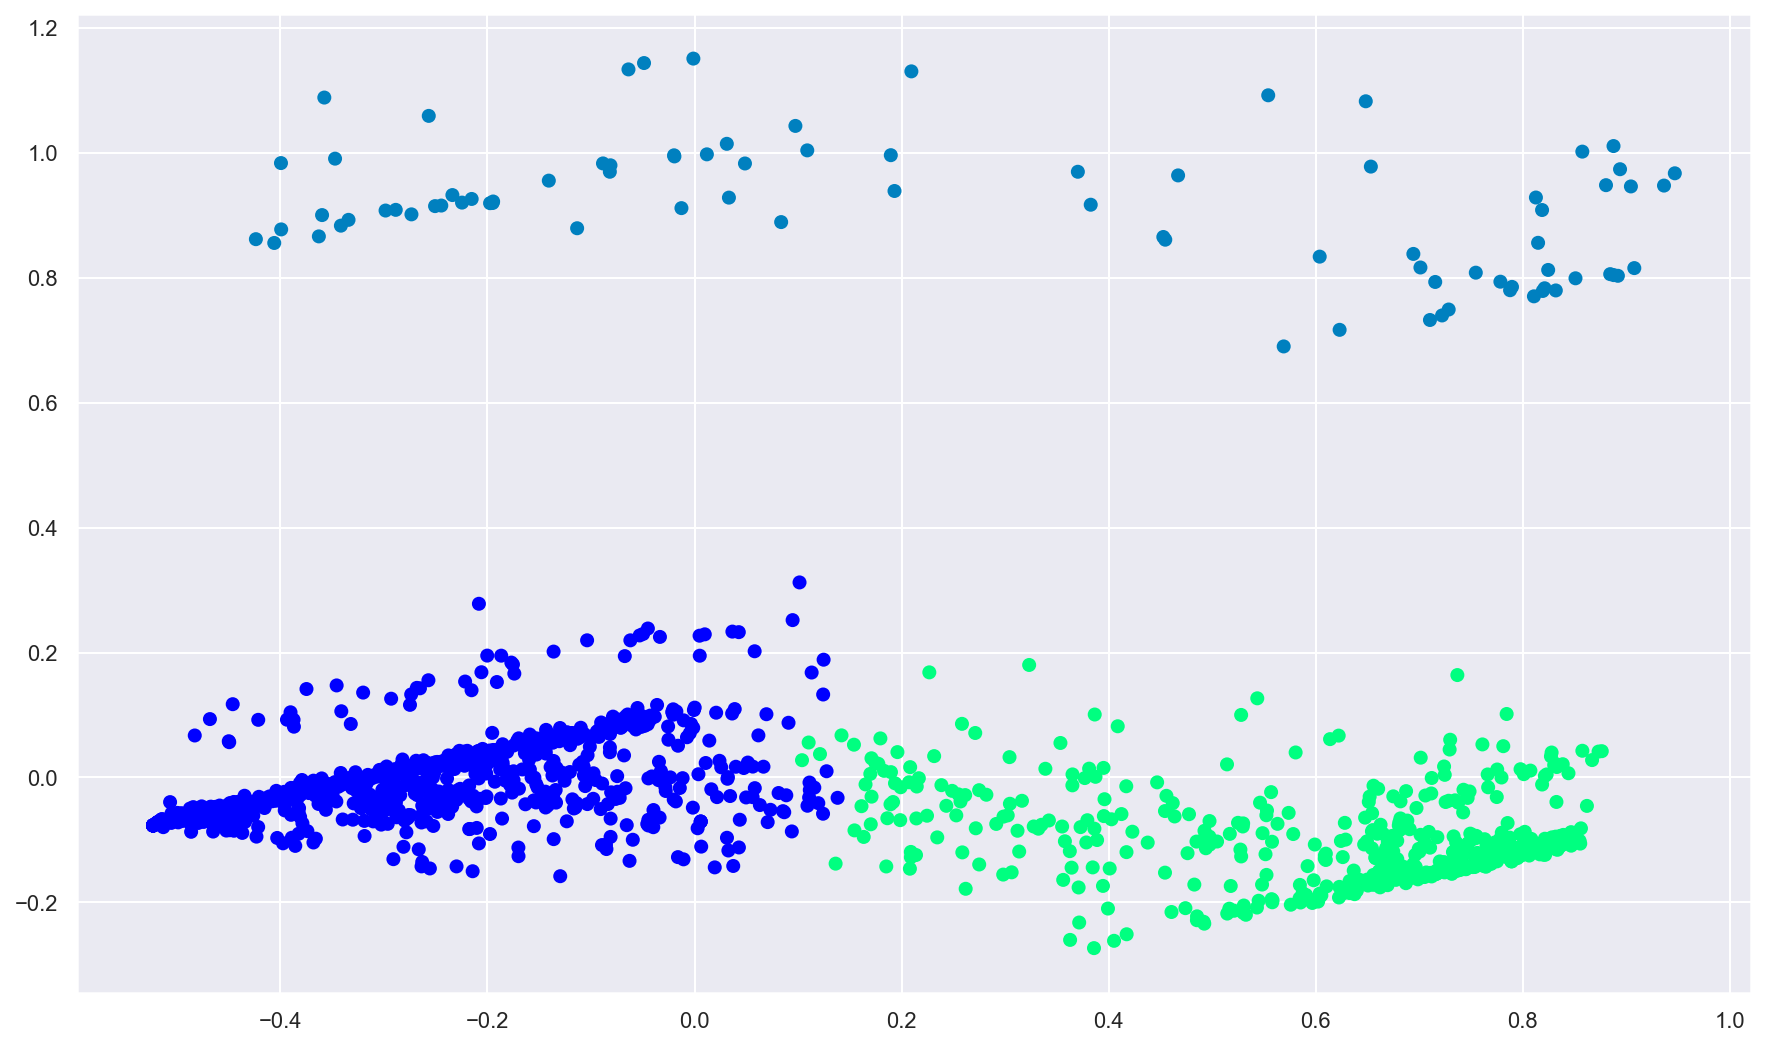

In [84]:
agg = AgglomerativeClustering(n_clusters=3)
agg.fit(X_principal)

sns.set(font_scale=1)
plt.scatter(
    X_principal["P1"],
    X_principal["P2"],
    c=AgglomerativeClustering(n_clusters=3).fit_predict(X_principal),
    cmap=plt.cm.winter,
)
plt.show()

### Elbow and silhouette scores - no PCA

Text(0, 0.5, 'Total within-cluster sum of squares')

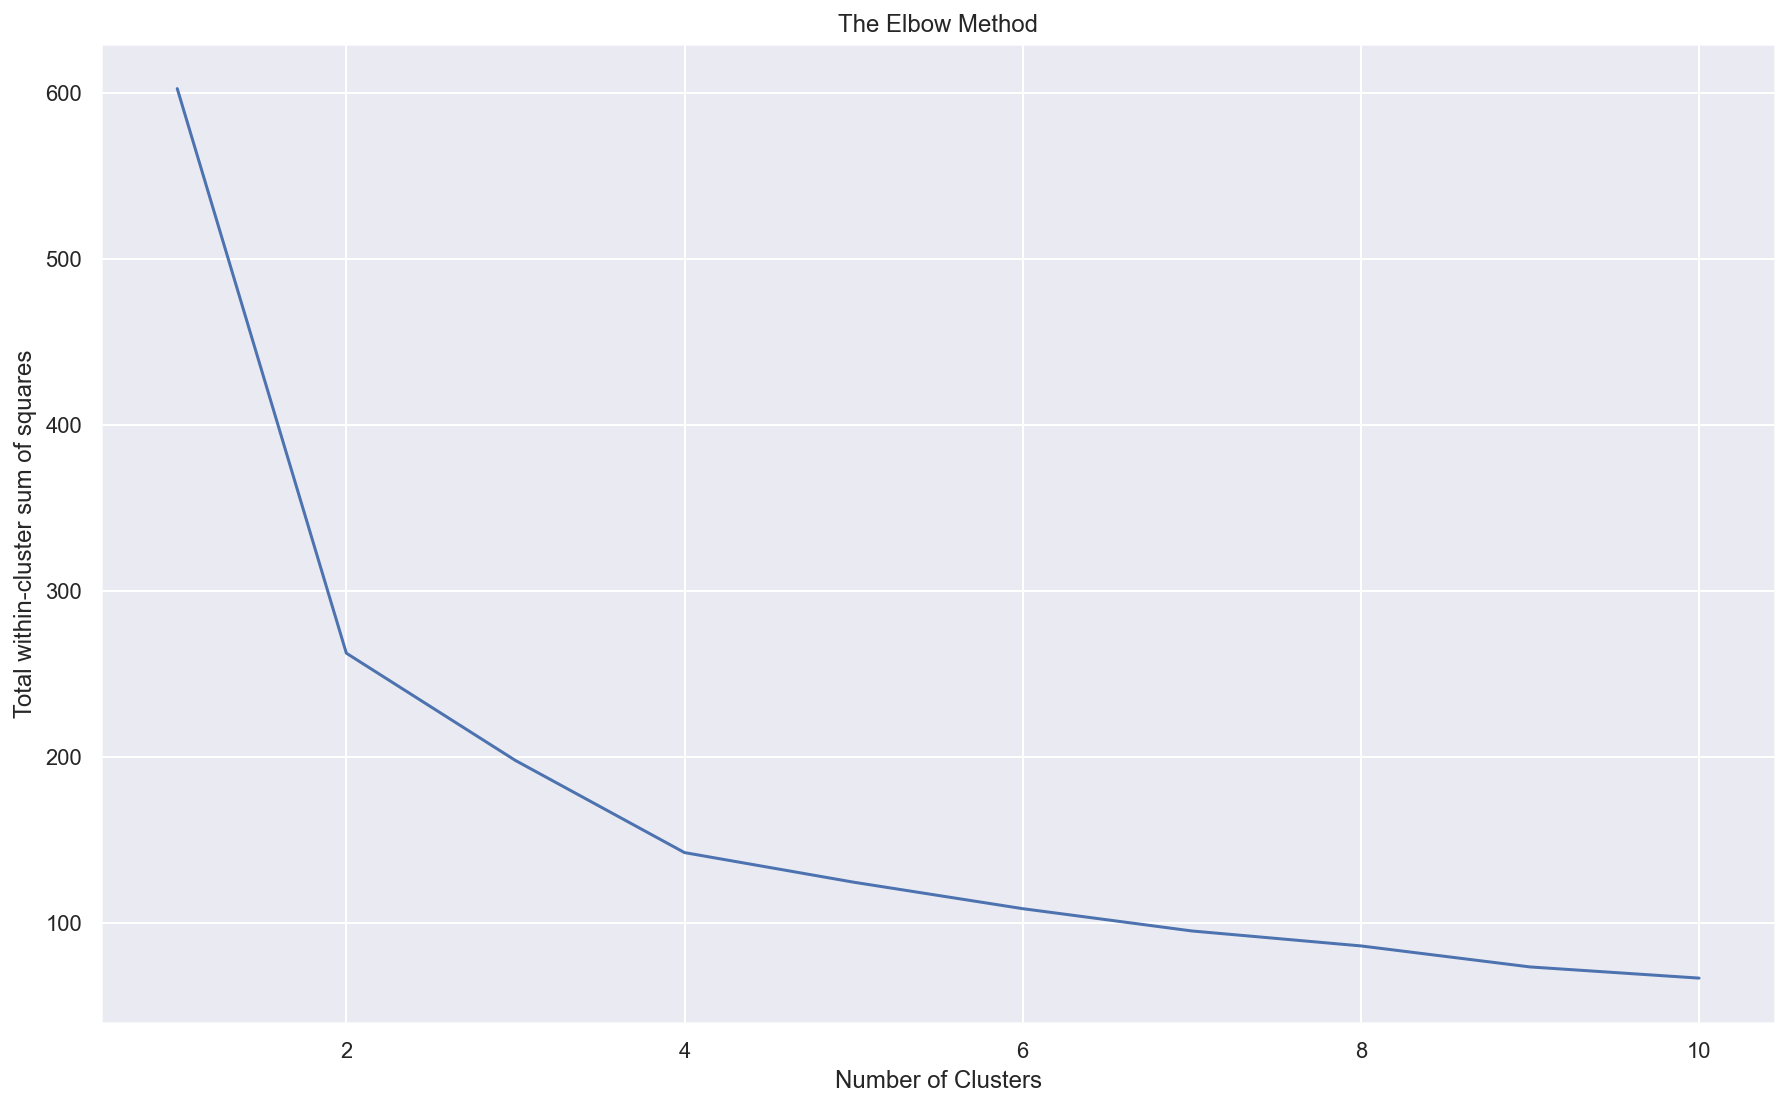

In [85]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

twss = []
sa = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++")
    kmeans.fit(X2)
    Ypreds = kmeans.predict(X2)
    twss.append(kmeans.inertia_)
    if i > 1:
        sa.append(silhouette_score(X2, Ypreds))


plt.plot(range(1, 11), twss)
plt.title("The Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Total within-cluster sum of squares")

Text(0, 0.5, 'Average silhouette score')

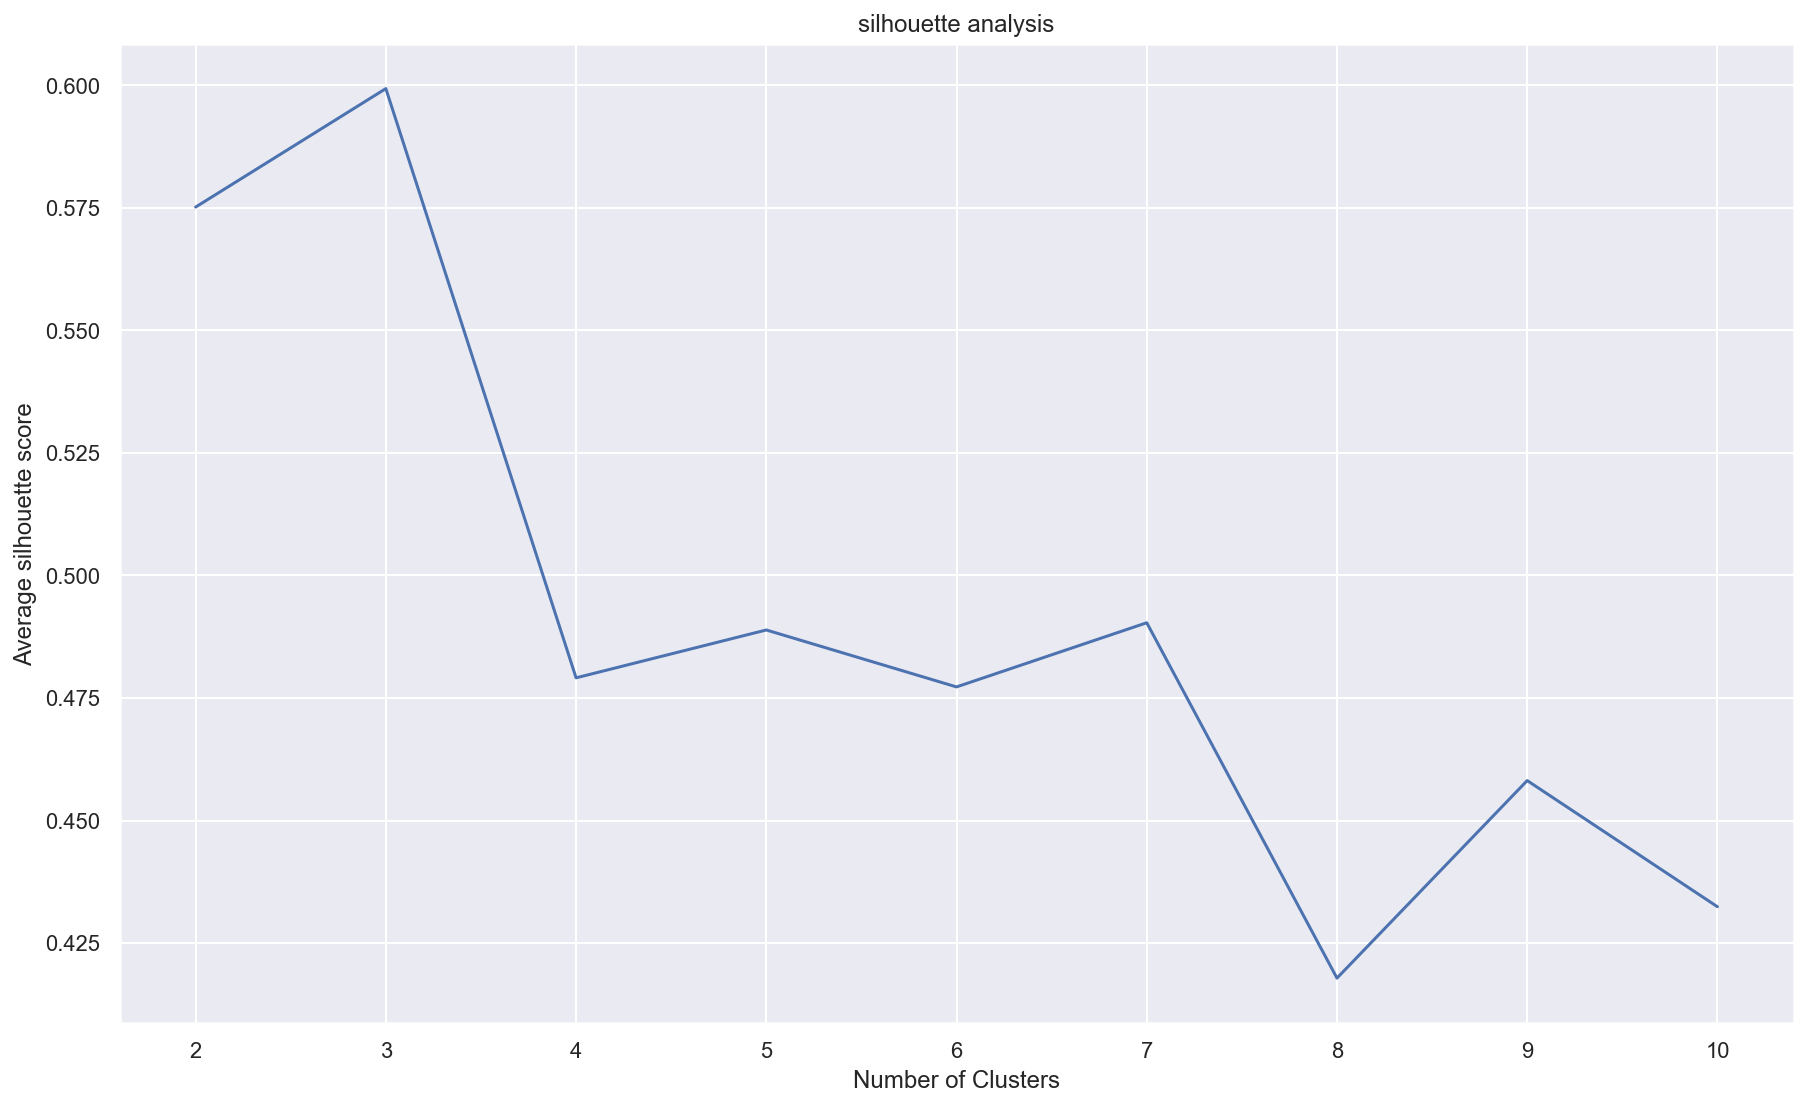

In [86]:
plt.plot(range(2, 11), sa)
plt.title("silhouette analysis")
plt.xlabel("Number of Clusters")
plt.ylabel("Average silhouette score")